<a href="https://colab.research.google.com/github/finardi/IA376A/blob/master/Paulo_Finardi_%5BWikitext_2%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nome: Paulo Finardi

# Libs

In [ ]:
!pip install -q torch_optimizer
import torch_optimizer as optim_
import collections
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

## Deterministics experiments

In [ ]:
manualSeed = 0

def deterministic(rep=True):
  if rep:
    np.random.seed(manualSeed)
    torch.manual_seed(manualSeed)
    if torch.cuda.is_available():
      torch.cuda.manual_seed(manualSeed)
      torch.cuda.manual_seed_all(manualSeed)
    torch.backends.cudnn.enabled = False 
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    print(f'Deterministic experiment, seed: {manualSeed}')
  else:
    print('Random experiment')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


# Download do dataset 

Iremos usar o dataset [Wikitext-2](https://blog.einstein.ai/the-wikitext-long-term-dependency-language-modeling-dataset/) para treinar e avaliar nosso modelo de linguagem.

In [ ]:
!wget -nc https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-v1.zip
!unzip -o wikitext-2-v1.zip

--2020-03-26 11:20:05--  https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-v1.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.82.211
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.82.211|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4475746 (4.3M) [application/zip]
Saving to: ‘wikitext-2-v1.zip’

wikitext-2-v1.zip   100%[===================>]   4.27M  2.90MB/s    in 1.5s    

2020-03-26 11:20:07 (2.90 MB/s) - ‘wikitext-2-v1.zip’ saved [4475746/4475746]

Archive:  wikitext-2-v1.zip
   creating: wikitext-2/
  inflating: wikitext-2/wiki.test.tokens  
  inflating: wikitext-2/wiki.valid.tokens  
  inflating: wikitext-2/wiki.train.tokens  


# Leitura e preparação do dataset e mini_batches

### Função load_data

In [ ]:
def load_data(path, size=10000):
  count, data, dic_wrd = [],[],{}
  # vocab_size = size
  words = open(path).read().lower().split()
  count = [['<UNK>', -1]]   
  vocab_size = size                 
  frq_word = collections.Counter(words)         # conta as words mais frequentes
  frq_word = frq_word.most_common(vocab_size-1) # usa somente o vocab_size
  count.extend(frq_word)  

  # Coloca todas as palaras no dict dict_wrd
  for word, _ in count:
    dic_wrd[word] = len(dic_wrd) 
    vocab_size = len(dic_wrd)
 
  # coloca todos os índices da palavra na lista data
  for w in words:
    idx = 0
    if w in dic_wrd:
      idx = dic_wrd[w]
    data.append(idx) # data <-- possui somente as palavras mais frequêntes

  return data, dict(zip(dic_wrd.values(), dic_wrd.keys()))

In [ ]:
# Transformar od dados em tensores
VOCAB = 10_000
train_data_list, r_tr = load_data('/content/wikitext-2/wiki.train.tokens', size=VOCAB)
train_data_tensor = torch.LongTensor(train_data_list)

valid_data_list, r_vl = load_data('/content/wikitext-2/wiki.valid.tokens', size=VOCAB)
valid_data_tensor = torch.LongTensor(valid_data_list)

test_data_list, r_ts  = load_data('/content/wikitext-2/wiki.test.tokens',  size=VOCAB)
test_data_tensor = torch.LongTensor(test_data_list)

print(f'Qtde de palavras únicas no conj. de treino: {len(set(train_data_list))}')
len(train_data_tensor), len(valid_data_tensor), len(test_data_tensor)

Qtde de palavras únicas no conj. de treino: 10000


(2051910, 213886, 241211)

### Função data2batch 
- Recebe o dado em forma de tensor e transforma em 2D

In [ ]:
def data2batch(data, batch_size):
  # nbatch divide o dado pelo tamanho do batch_size
  nbatch = data.size(0) // batch_size
  # remove o resto de uma possível div com resto
  data = data.narrow(0, 0, nbatch * batch_size)
  # divide os dados entre os batches com shape 2D
  data = data.view(batch_size, -1).t().contiguous()
  return data

In [ ]:
BATCH_SZ = 100
CUT_SIZE = 2000

train_loader = data2batch(train_data_tensor[:CUT_SIZE], BATCH_SZ)
valid_loader = data2batch(valid_data_tensor[:CUT_SIZE], BATCH_SZ)
test_loader  = data2batch(test_data_tensor[:CUT_SIZE],  BATCH_SZ)
len(train_loader), len(valid_loader), len(test_loader)

(20, 20, 20)

### Função get_batch
- pega a linha com a seq. e o target

In [ ]:
SEQ_LEN = 5
def get_batch(source, i):
  seq_len = SEQ_LEN
  x = source[i:i+seq_len]
  y = source[i+seq_len]
  return x,y

# Transforma o input em One hot

In [ ]:
def one_hot(sequence, dict_size = VOCAB, seq_len = SEQ_LEN, batch_size= BATCH_SZ):
  features = np.zeros((seq_len, batch_size, dict_size), dtype=np.float32)
  for i in range(seq_len):
    for u in range(batch_size):
      features[i, u, sequence[i][u]] = 1
  return torch.LongTensor(features)

## Testando

In [ ]:
# load_data 
data, r = load_data('/content/wikitext-2/wiki.train.tokens', 10000)
data[:8]

[10, 3816, 3879, 885, 10, 0, 108, 3816]

In [ ]:
# Get_Batch com ONE HOT
for batch, i in enumerate(range(0,train_loader.size(0)-5, 1)):
  data, targets = get_batch(train_loader, i)
  data_one_hot  = one_hot(data, VOCAB, SEQ_LEN, BATCH_SZ)
  print(f'input: {data_one_hot}')
  # print(f'target:{targets}')

input: tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [1, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 1, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 1,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 1, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 1, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0, 

In [ ]:
# get_batch
for batch, i in enumerate(range(0,train_loader.size(0)-5, 1)):
  data, targets = get_batch(train_loader, i)
  print(f'input: {data}')
  print(f'target:{targets}')

input: tensor([[  10,    4,   13,    2,   63,    2,    6,   69,    1,  283,    0,   80,
            3,   24,  308,   12,    1,    9, 1814, 3542,    2,    8, 1276, 1301,
         1315,   85,  312,    1,    2, 1276,  393,    3,  117,    2,  283,   11,
            0,    8, 7170,    5,    1,    6,  170,   36,  649,   20,   10,   45,
            6,   20,   43,    3,    8,   55,    4, 2319,    2, 2629,    2,    3,
            4,  160,    3,    1,    3,    2,    1,    6,    2, 1885,    0,  311,
           17,  137,  299,   13, 4060,   10,   19,   16,  308,  291,   12,  746,
            7,   37,    8, 3879,  373,   20,    6,    1,    1,  122,   17,   15,
            0,   57,    0, 1644],
        [3816,    1,  575,   24, 2100,    9,   34,    9,   97, 3756,    0,    0,
           47,   12,    2,  159, 1764, 5694,  339,  113, 2051,  158,    2,    2,
         3647,    4,    0,   71,  456,    2,  468,  158,   33,   93,   52,    2,
            9,    9,   13,   16, 5039,  361, 2570, 1110,    7,    1,

In [ ]:
# teste do dict idx com a palavra associada 
r_tr.items()

dict_items([(0, '<UNK>'), (1, 'the'), (2, ','), (3, '.'), (4, 'of'), (5, '<unk>'), (6, 'and'), (7, 'in'), (8, 'to'), (9, 'a'), (10, '='), (11, '"'), (12, 'was'), (13, '@-@'), (14, 'on'), (15, 'as'), (16, 'that'), (17, "'s"), (18, 'for'), (19, 'with'), (20, 'by'), (21, ')'), (22, '('), (23, 'is'), (24, 'it'), (25, 'from'), (26, 'at'), (27, 'his'), (28, 'he'), (29, 'were'), (30, 'an'), (31, 'had'), (32, 'which'), (33, 'be'), (34, 'are'), (35, 'this'), (36, 'their'), (37, 'first'), (38, 'but'), (39, ';'), (40, 'not'), (41, '–'), (42, 'one'), (43, 'they'), (44, 'its'), (45, 'also'), (46, ':'), (47, 'after'), (48, 'her'), (49, 'or'), (50, 'two'), (51, 'have'), (52, 'has'), (53, 'been'), (54, '@.@'), (55, 'who'), (56, 'she'), (57, "'"), (58, 'new'), (59, 'other'), (60, '@,@'), (61, 'during'), (62, 'when'), (63, 'time'), (64, 'all'), (65, 'into'), (66, 'more'), (67, 'would'), (68, '1'), (69, 'over'), (70, 'while'), (71, 'game'), (72, 'only'), (73, 'i'), (74, 'most'), (75, '2'), (76, 'three'),

# Foto do modelo / Minha implementação
- Utilizei os mesmos nomes das variáveis do artigo para fazer a saída do modelo com as linahs tracejadas (somado no final) igual a equação 1. 

<img src="https://drive.google.com/uc?id=1iBPLXCAYYQDamkmDGOYh6esoKDY3s-JQ" alt="drawing" width="500"/>



# Neural Probabilistic Language Model (NPLM)
- Usei o Xavier Glorot para iniciar os pesos, detelhes nesse [artigo:](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)

In [ ]:
########## 
# Legenda: w_size*emb_dim=SE | vocab=V | h_neur=H_NEUR | batch=N 
##########

class NPLM(nn.Module):
  def __init__(self, vocab, w_size, emb_dim, h_neur):
    super(NPLM, self).__init__()
    
    self.emb_dim = emb_dim
    self.w_size  = w_size
    self.emb     = nn.Embedding(vocab, self.emb_dim, scale_grad_by_freq=True)
    self.activation = nn.Tanh() 
    
    self.H = nn.Linear(self.w_size * self.emb_dim, h_neur, bias=False) # (SE,H_NEUR)
    self.H = nn.init.xavier_uniform_(self.H.weight)                    # Xavier init.

    self.d = nn.Parameter(torch.randn(h_neur).type(torch.FloatTensor)) # H (bias)
    self.d = nn.init.ones_(self.d)                                     # ones init 

    self.U = nn.Linear(h_neur, vocab, bias=False)                      # (H_NEUR,V)        
    self.U = nn.init.xavier_uniform_(self.U.weight)                    # Xavier init.
    
    self.b = nn.Parameter(torch.randn(vocab).type(torch.FloatTensor))  # V (bias)
    self.b = nn.init.ones_(self.b)                                     # ones init

    self.W = nn.Linear(self.w_size * self.emb_dim, vocab, bias=False)  # (SE,V)
    self.W = nn.init.xavier_uniform_(self.W.weight)                    # Xavier init.

  def forward (self, x): 
    """ Utilizando os mesmos nomes de variáveis do artigo """
    b, W, d, H, U = self.b, self.W.T, self.d, self.H.T, self.U.T

    x     = self.emb(x)  # (N,S,E)
    x     = x.view(-1, self.w_size * self.emb_dim) # (N,SE)
    Hx    = torch.einsum('ij,jk->ik', x,H)         # (N,SE)x(SE,H_NEUR)=(N,H_NEUR) 
    tanh  = self.activation(d + Hx)                # (N,H_NEUR)
    Utan_d_Hx = torch.einsum('ij,jk->ik', tanh,U)  # (N,H_NEUR)x(H_NEUR,V)=(N,V)
    Wx    = torch.einsum('ij,jk->ik', x,W)         # (N,SE)x(SE,X)=(N,V)
    b_Wx  = b + Wx                                 # V+(N,V) 
    
    y = b_Wx + Utan_d_Hx # equação (1) do artigo 
    return y

###############
# sanity check
###############
WINDOW_SIZE = 5   # S 
EMB_DIM     = 64  # E
H_NEUR      = 128 # num. neurons 

model = NPLM(VOCAB, WINDOW_SIZE, EMB_DIM, H_NEUR).to(device)
x, _ = get_batch(train_loader, 0)
model(x.to(device)).shape

torch.Size([100, 10000])

# Modelo com Matriz W = 0

In [ ]:
########## 
# Legenda: w_size*emb_dim=SE | vocab=V | h_neur=H_NEUR | batch=N 
##########

class NPLMW0(nn.Module):
  def __init__(self, vocab, w_size, emb_dim, h_neur):
    super(NPLMW0, self).__init__()
    
    self.emb_dim = emb_dim
    self.w_size  = w_size
    self.emb     = nn.Embedding(vocab, self.emb_dim, scale_grad_by_freq=True)
    self.activation = nn.Tanh() 
    
    self.H = nn.Linear(self.w_size * self.emb_dim, h_neur, bias=False) # (SE,H_NEUR)
    self.H = nn.init.xavier_uniform_(self.H.weight)                    # Xavier init.

    self.d = nn.Parameter(torch.randn(h_neur).type(torch.FloatTensor)) # H (bias)
    self.d = nn.init.ones_(self.d)                                     # ones init 

    self.U = nn.Linear(h_neur, vocab, bias=False)                      # (H_NEUR,V)        
    self.U = nn.init.xavier_uniform_(self.U.weight)                    # Xavier init.
    
  def forward (self, x): 
    """ Utilizando os mesmos nomes de variáveis do artigo """
    d, H, U = self.d, self.H.T, self.U.T
    x     = self.emb(x)  # (N,S,E)
    x     = x.view(-1, self.w_size * self.emb_dim) # (N,SE)
    Hx    = torch.einsum('ij,jk->ik', x,H)         # (N,SE)x(SE,H_NEUR)=(N,H_NEUR) 
    tanh  = self.activation(d + Hx)                # (N,H_NEUR)
    Utan_d_Hx = torch.einsum('ij,jk->ik', tanh,U)  # (N,H_NEUR)x(H_NEUR,V)=(N,V)
    Utan_d_Hx = Utan_d_Hx.view(Utan_d_Hx.size(0), -1)
    y = Utan_d_Hx 
    return y

###############
# sanity check
###############
WINDOW_SIZE = 5   # S 
EMB_DIM     = 64  # E
H_NEUR      = 128 # num. neurons 

model = NPLMW0(VOCAB, WINDOW_SIZE, EMB_DIM, H_NEUR).to(device)
x, _ = get_batch(train_loader, 0)
model(x.to(device)).shape

torch.Size([100, 10000])

In [ ]:
# Count params
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 1,961,088 trainable parameters


In [ ]:
sum([torch.tensor(x.size()).prod() for x in model.parameters()])
[x.size() for x in model.parameters()]

[torch.Size([1280, 3200]),
 torch.Size([1280]),
 torch.Size([10000, 1280]),
 torch.Size([10000, 64])]

# Funções Train and Eval 

In [ ]:
def train(model, device, train_loader, loss_fn, optimizer):
  model.train()
  loss_train = []
  for batch, i in enumerate(range(0,train_loader.size(0)-5, 1)):
    x, y =  get_batch(train_loader, i)
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    output = model(x)
    loss = criterion(output, y)
    loss_train.append(loss.item())
    loss.backward()
    optimizer.step()
  ave_train_loss = sum(loss_train) / len(loss_train)
  return ave_train_loss, np.exp(ave_train_loss)

def test(model, device, valid_loader, criterion):
  model.eval()
  loss_test = []
  with torch.no_grad():
    for batch, i in enumerate(range(0,valid_loader.size(0)-5, 1)):
      x, y =  get_batch(valid_loader, i)
      x, y = x.to(device), y.to(device)
      output = model(x)
      loss = criterion(output, y)
      loss_test.append(loss.item())
    ave_test_loss = sum(loss_test) / len(loss_test)
  return ave_test_loss, np.exp(ave_test_loss)

# Loop de treino - Modelo igual do Artigo


In [ ]:
%%time
deterministic()

model = NPLM(VOCAB, WINDOW_SIZE, EMB_DIM, H_NEUR).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

N_EPOCH = 20
ppl_train, ppl_test = [], []
for step in range(N_EPOCH):
  lossT, perpT = train(model, device, train_loader, criterion, optimizer)
  lossV, perpV =  test(model, device, valid_loader, criterion)
  ppl_train.append(perpT)
  ppl_test.append(perpV)
  print(f'Epoch: [{step}/{N_EPOCH}] -- loss_train: {lossT :.6f} -- loss_valid: {lossV :.6f} -- ', end='')
  print(f'Ppl train: {perpT :.2f} | ', end='')
  print(f'Ppl valid: {perpV :.2f}')

Deterministic experiment, seed: 0
Epoch: [0/20] -- loss_train: 8.794412 -- loss_valid: 8.628419 -- Ppl train: 6597.28 | Ppl valid: 5588.24
Epoch: [1/20] -- loss_train: 7.553711 -- loss_valid: 8.192291 -- Ppl train: 1907.81 | Ppl valid: 3612.99
Epoch: [2/20] -- loss_train: 6.752996 -- loss_valid: 7.952574 -- Ppl train: 856.62 | Ppl valid: 2842.88
Epoch: [3/20] -- loss_train: 6.196258 -- loss_valid: 7.829876 -- Ppl train: 490.91 | Ppl valid: 2514.62
Epoch: [4/20] -- loss_train: 5.747495 -- loss_valid: 7.770246 -- Ppl train: 313.40 | Ppl valid: 2369.05
Epoch: [5/20] -- loss_train: 5.358220 -- loss_valid: 7.737850 -- Ppl train: 212.35 | Ppl valid: 2293.54
Epoch: [6/20] -- loss_train: 5.008954 -- loss_valid: 7.718651 -- Ppl train: 149.75 | Ppl valid: 2249.92
Epoch: [7/20] -- loss_train: 4.691173 -- loss_valid: 7.706605 -- Ppl train: 108.98 | Ppl valid: 2222.98
Epoch: [8/20] -- loss_train: 4.398926 -- loss_valid: 7.699191 -- Ppl train: 81.36 | Ppl valid: 2206.56
Epoch: [9/20] -- loss_train: 

# Loop de treino - Modelo W=0


In [ ]:
%%time
deterministic()

model = NPLMW0(VOCAB, WINDOW_SIZE, EMB_DIM, H_NEUR).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

N_EPOCH = 20
ppl_trainW0, ppl_testW0 = [], []
for step in range(N_EPOCH):
  lossT, perpTW0 = train(model, device, train_loader, criterion, optimizer)
  lossV, perpVW0 =  test(model, device, valid_loader, criterion)
  ppl_trainW0.append(perpTW0)
  ppl_testW0.append(perpVW0)
  print(f'Epoch: [{step}/{N_EPOCH}] -- loss_train: {lossT :.6f} -- loss_valid: {lossV :.6f} -- ', end='')
  print(f'Ppl train: {perpTW0 :.2f} | ', end='')
  print(f'Ppl valid: {perpVW0 :.2f}')

Deterministic experiment, seed: 0
Epoch: [0/20] -- loss_train: 8.832861 -- loss_valid: 8.648050 -- Ppl train: 6855.87 | Ppl valid: 5699.02
Epoch: [1/20] -- loss_train: 7.967171 -- loss_valid: 8.189493 -- Ppl train: 2884.68 | Ppl valid: 3602.89
Epoch: [2/20] -- loss_train: 7.384885 -- loss_valid: 7.921771 -- Ppl train: 1611.44 | Ppl valid: 2756.65
Epoch: [3/20] -- loss_train: 7.047183 -- loss_valid: 7.757270 -- Ppl train: 1149.62 | Ppl valid: 2338.51
Epoch: [4/20] -- loss_train: 6.807033 -- loss_valid: 7.668054 -- Ppl train: 904.18 | Ppl valid: 2138.92
Epoch: [5/20] -- loss_train: 6.621049 -- loss_valid: 7.617543 -- Ppl train: 750.73 | Ppl valid: 2033.56
Epoch: [6/20] -- loss_train: 6.464970 -- loss_valid: 7.585390 -- Ppl train: 642.25 | Ppl valid: 1969.21
Epoch: [7/20] -- loss_train: 6.328374 -- loss_valid: 7.562866 -- Ppl train: 560.24 | Ppl valid: 1925.36
Epoch: [8/20] -- loss_train: 6.206532 -- loss_valid: 7.545804 -- Ppl train: 495.98 | Ppl valid: 1892.78
Epoch: [9/20] -- loss_trai

# Modelo One-hot

In [ ]:
def train_one_hot(model, device, train_loader, loss_fn, optimizer):
  model.train()
  loss_train = []
  for batch, i in enumerate(range(0,train_loader.size(0)-5, 1)):
    x, y =  get_batch(train_loader, i)
    x    = one_hot(x, VOCAB, SEQ_LEN, BATCH_SZ)
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    output = model(x)
    loss = criterion(output, y)
    loss_train.append(loss.item())
    loss.backward()
    optimizer.step()
  ave_train_loss = sum(loss_train) / len(loss_train)
  return ave_train_loss, np.exp(ave_train_loss)

def test_one_hot(model, device, valid_loader, criterion):
  model.eval()
  loss_test = []
  with torch.no_grad():
    for batch, i in enumerate(range(0,valid_loader.size(0)-5, 1)):
      x, y =  get_batch(valid_loader, i)
      x    =  one_hot(x, VOCAB, SEQ_LEN, BATCH_SZ)
      x, y = x.to(device), y.to(device)
      output = model(x)
      loss = criterion(output, y)
      loss_test.append(loss.item())
    ave_test_loss = sum(loss_test) / len(loss_test)
  return ave_test_loss, np.exp(ave_test_loss)


  %%time
deterministic()

model = NPLMW0(VOCAB, WINDOW_SIZE, EMB_DIM, H_NEUR).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

N_EPOCH = 20
ppl_trainOH, ppl_testOH = [], []
for step in range(N_EPOCH):
  lossTOH, perpTOH = train_one_hot(model, device, train_loader, criterion, optimizer)
  lossVOH, perpVOH =  test_one_hot(model, device, valid_loader, criterion)
  ppl_trainOH.append(perpTOH)
  ppl_testOH.append(perpVOH)
  print(f'Epoch: [{step}/{N_EPOCH}] -- loss_train: {lossTOH :.6f} -- loss_valid: {lossVOH :.6f} -- ', end='')
  print(f'Ppl train: {perpTOH :.2f} | ', end='')
  print(f'Ppl valid: {perpVOH :.2f}')

# Perplexidade por epoch

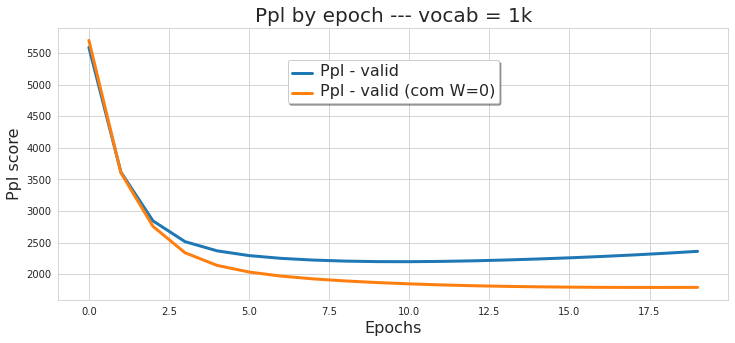

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 5)
x = np.arange(N_EPOCH)
sns.set_style("whitegrid")

ax = sns.lineplot(x, ppl_test, legend='full', label='Ppl - valid', lw=3) 
ax = sns.lineplot(x, ppl_testW0, legend='full', label='Ppl - valid (com W=0)', lw=3) 

ax.set_xlabel('Epochs', fontsize=16)
ax.set_ylabel('Ppl score', fontsize=16)
ax.set_title('Ppl by epoch --- vocab = 1k', fontsize=20)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[:], labels=labels[:], 
          loc='upper center', bbox_to_anchor=(0.5, 0.9),
          ncol=1, fancybox=True, shadow=True)

plt.setp(ax.get_legend().get_texts(), fontsize='16')
plt.show()

# Avaliando no Conj. de testes

In [ ]:
_, perp_test = test(model, device, test_loader, criterion)
print(f'Ppl test: {perp_test :.5f}')

Ppl test: 1272.71290


# DataFrame das palavras preditas

In [ ]:
true_word, predict_word = [], []
test_loader  = data2batch(test_data_tensor, 1)
model.eval()
with torch.no_grad():
  for batch, i in enumerate(range(0,test_loader.size(0)-6)):
    x, y =  get_batch(test_loader, i)
    x, y = x.to(device), y.to(device)
    predict_word.append(r[int(model(x).data.max(1, keepdim = True)[1])])
    true_word.append(r[int(y)])    

In [ ]:
import pandas as pd 
df = pd.DataFrame({'TrueWord': true_word, 'PredictWord': predict_word})

# Verificando os Mathces
df['Match'] = np.where(df.TrueWord == df.PredictWord, True, False)
print(f'De {df.Match.value_counts()[0]} palavras, o modelo fez a correta predição em: {df.Match.value_counts()[1]}.')
print(f'\tOu {df.Match.value_counts()[1]/df.Match.value_counts()[0]*100 :.3}% predições corretas no conj. de testes.')
print(f'\tOs números consideram o token especial <UNK>')
df[20:25]

De 231992 palavras, o modelo fez a correta predição em: 9213.
	Ou 3.97% predições corretas no conj. de testes.
	Os números consideram o token especial <UNK>


,TrueWord,PredictWord,Match
20,command,<UNK>,False
21,area,<UNK>,False
22,the,<UNK>,False
23,headed,<UNK>,False
24,in,<UNK>,False


## end of notebook